In [210]:
import numpy as np
import numpy.random as rand
from functools import cache
import polars as pl
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [211]:
TARGET = "quality"
df = pl.read_csv("data/Wine_Quality_Data.csv", has_header=True)
df = df.drop("color")
df = df.head(1000)

In [212]:
df.describe()

describe,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",8.7289,0.52829,0.29458,2.5794,0.090375,15.171,48.328,0.997349,3.2991,0.66852,10.2407,5.594
"""std""",1.836602,0.17855,0.200153,1.23896,0.049917,9.972949,33.309788,0.001778,0.157948,0.18321,1.033161,0.798625
"""min""",4.6,0.12,0.0,1.2,0.012,1.0,6.0,0.99064,2.74,0.33,8.4,3.0
"""max""",15.9,1.33,1.0,15.5,0.611,68.0,165.0,1.0032,3.9,2.0,14.9,8.0
"""median""",8.3,0.52,0.28,2.3,0.081,13.0,39.0,0.9973,3.3,0.62,9.9,5.0


In [213]:
from sklearn.model_selection import KFold
import polars as pl
import itertools

def fetch_data(df, use_split, rbf, include_mul, raw_vals):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=4, shuffle=True, random_state=2023)
    splits = list(kf.split(df))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    for col in df_train.columns:
        if col == TARGET or col in rbf:
            continue
        df_train, df_test = scale_column(df_train, df_test, col)
    cols = list(df_train.columns)
    # binary = binary_columns(df_train)
    for (idx, col) in enumerate(rbf):
        if col == TARGET:
            continue
        dist = int(10 * abs(0.5 - raw_vals[idx]))
        df_train, df_test = rbf_column(df_train, df_test, col, num_features=dist) # Use radial bias function
    for (idx, col) in enumerate(cols):
        if col == TARGET:
            continue
        if col not in rbf:
            dist = int(10 * abs(0.5 - raw_vals[idx]))
            df_train, df_test = fourier_column(df_train, df_test, col, num_features=dist)
    for (col_a, col_b) in itertools.combinations(cols, 2):
        if col_a == TARGET or col_b == TARGET:
            continue
        if col_a not in include_mul and col_b not in include_mul:
            continue
        df_train, df_test = mul_cols(df_train, df_test, col_a, col_b)
    return df_train, df_test

def binary_columns(df):
    binary = []
    for col in df.columns:
        if df.get_column(col).n_unique() == 2:
            binary.append(col)
    return binary

def scale_column(df_train, df_test, col_name):
    '''Scale a column from 0 to 1'''
    max = df_train.get_column(col_name).max()
    min = df_train.get_column(col_name).min()
    df_train = df_train.with_columns((pl.col(col_name) - min) / (max - min))
    df_test = df_test.with_columns((pl.col(col_name) - min) / (max - min))
    return df_train, df_test

def rbf_column(df_train, df_test, col_name, num_features=3):
    '''Divide a col into 3 features using a radial basis function'''
    std = df_train.get_column(col_name).std()
    select = []
    if num_features == 2:
        low = df_train.get_column(col_name).quantile(0.25)
        high = df_train.get_column(col_name).quantile(0.75)
        select = [low, high]
    elif num_features == 3:
        low = df_train.get_column(col_name).quantile(0.25)
        middle = df_train.get_column(col_name).quantile(0.5)
        high = df_train.get_column(col_name).quantile(0.75)
        select = [low, middle, high]
    elif num_features == 4:
        low = df_train.get_column(col_name).quantile(0.2)
        middle = df_train.get_column(col_name).quantile(0.4)
        high = df_train.get_column(col_name).quantile(0.6)
        higher = df_train.get_column(col_name).quantile(0.8)
        select = [low, middle, high, higher]
    elif num_features == 5:
        low = df_train.get_column(col_name).quantile(0.15)
        middle = df_train.get_column(col_name).quantile(0.3)
        high = df_train.get_column(col_name).quantile(0.45)
        higher = df_train.get_column(col_name).quantile(0.6)
        highest = df_train.get_column(col_name).quantile(0.75)
        select = [low, middle, high, higher, highest]
    for i, val in enumerate(select):
        df_train = df_train.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
        df_test = df_test.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
    return df_train, df_test

def fourier_column(df_train, df_test, col_name, num_features=3):
    '''Divide a col in 3 features using math'''
    for i in range(1, num_features + 1):
        df_train = df_train.with_columns((pl.col(col_name) * pl.lit(i) * pl.lit(np.pi)).cos().alias(f"{col_name}_{i - 1}"))
        df_test = df_test.with_columns((pl.col(col_name) * pl.lit(i) * pl.lit(np.pi)).cos().alias(f"{col_name}_{i - 1}"))
    return df_train, df_test

def mul_cols(df_train, df_test, col_a, col_b):
    df_train = df_train.with_columns((pl.col(col_a) * pl.col(col_b)).alias(f"{col_a}+{col_b}"))
    df_test = df_test.with_columns((pl.col(col_a) * pl.col(col_b)).alias(f"{col_a}+{col_b}"))
    return df_train, df_test

def get_x_y(df):
    X, y = df.drop(TARGET), df.get_column(TARGET)
    return X.to_numpy(), y.to_numpy()

NUM_FEATURES = len(df.columns) - 1
df_train, df_test = fetch_data(df, 0, list(df.columns)[11:], [], np.ones(NUM_FEATURES * 2))
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
len(y_train)

750

In [214]:
NUM_FEATURES

11

In [215]:
a = np.array(list(df.columns[1:]) + list(df.columns[1:]))
len(a)

22

In [244]:
def evaluate(input, method='tree'): # method = tree, svm, logistic, knn
    a = np.array(list(df.columns[1:]) + list(df.columns[1:]))
    rbf = a[input > 0.5]
    
    df_train, df_test = fetch_data(df, 0, rbf[:NUM_FEATURES], rbf[NUM_FEATURES:], input)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)

    if method == 'logistic': reg = LogisticRegression(solver="newton-cg", random_state=420)
    elif method == 'svm': reg = LinearSVC(random_state=420)
    elif method == 'tree': reg = DecisionTreeClassifier(random_state=420)
    elif method == 'knn': reg = KNeighborsClassifier(random_state=420)
    else: reg = None

    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

In [217]:
arr = np.ones(NUM_FEATURES * 2)
arr[NUM_FEATURES:] = 0.6
evaluate(arr)

0.644

In [218]:
np.array(list(df.columns[1:]))

array(['volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
       'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'quality'], dtype='<U20')

In [219]:
list(df.columns)[2:]

['citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [220]:
NUM_DIM = NUM_FEATURES * 2
LIMIT = 4

class Configuration:
    def __init__(self, array):
        self.data = np.clip(array, 0.0, 1.0)

    def __hash__(self):
        return hash(self.data.tobytes())
    
    def __eq__(self, other):
        return (self.data == other.data).all()

class Solutions:
    def __init__(self, num, ring_size=4):
        self.solutions = np.stack([Solutions.new_solution() for _ in range(num)])
        self.employed = np.array([True] * (num // 2) + [False] * (num // 2))
        self.failures = np.zeros_like(self.employed, np.int32)
        self.onlooker = np.logical_not(self.employed) # Unemployed
        self.best_fitness = -1
        self.best_sol = None 
        self.ring_size = ring_size

    @staticmethod
    def new_solution():
        return rand.random(size=NUM_DIM)
    
    def best_in_ring(self, start_idx):
        # sol = self.solutions[start_idx]
        size = len(self.solutions)
        best_idx = start_idx 
        for i in range(1, 1 + self.ring_size):
            idx = (start_idx - i) % size
            if self.fitness(self.solutions[idx]) > self.fitness(self.solutions[best_idx]):
                best_idx = idx
        for i in range(1, 1 + self.ring_size):
            idx = (start_idx + i) % size
            if self.fitness(self.solutions[idx]) > self.fitness(self.solutions[best_idx]):
                best_idx = idx
        return best_idx
        

    def random_sol(self, exclude=-1):
        rand_idx = rand.randint(0, self.solutions.shape[0])
        if rand_idx == exclude:
            return self.random_sol(exclude=exclude)
        else:
            return self.solutions[rand_idx]

    def get_employed(self):
        return self.solutions[self.employed]

    def get_unemployed(self):
        return self.solutions[np.logical_not(self.employed)]
        
    def get_onlooker(self):
        return self.solutions[self.onlooker]

    def get_scout(self):
        return self.solutions[self.scout]

    def fitness(self, x):
        return _fitness(Configuration(x))

    def most_fit(self):
        fit = np.array([self.fitness(x) for x in self.solutions])
        idx = fit.argmax()
        return fit[idx], self.solutions[idx]

    def update_best(self):
        best_fit, best_sol = self.most_fit()
        if best_fit > self.best_fitness:
            self.best_sol = best_sol
            self.best_fitness = best_fit

@cache
def _fitness(x: Configuration):
    return evaluate(x.data)

def basic_employed(sol: Solutions, initial_idx: int):
    initial = sol.solutions[initial_idx]
    a = 0.1 
    idx = rand.randint(0, initial.size)
    phi = rand.uniform(low=-a, high=a)
    out = np.copy(initial)
    sol_k = sol.random_sol(exclude=initial_idx)
    out[idx] += phi * (out[idx] - sol_k[idx])
    out[idx] = abs(out[idx])
    # Todo make sure values stay within expected range
    return out # Greedy select this

def enhanced_employed(sol: Solutions, initial_idx: int):
    initial = sol.solutions[initial_idx]
    a = 0.1
    idx = rand.randint(0, initial.size)
    phi = rand.uniform(low=-a, high=a)
    out = np.copy(initial)
    best_idx = sol.best_in_ring(initial_idx)
    sol_k = sol.solutions[best_idx]
    out[idx] += phi * (out[idx] - sol_k[idx])
    out[idx] = abs(out[idx])
    return out


def basic_onlooker(sol: Solutions, _initial_idx: int):
    employed = sol.get_employed()
    fitnesses = np.array([sol.fitness(x) for x in employed])
    total_fitness = np.sum(fitnesses)
    bee_idx = rand.choice(np.arange(len(employed)), p=fitnesses/total_fitness)
    return basic_employed(sol, bee_idx)

def enhanced_onlooker(sol: Solutions, initial_idx: int):
    best_bee = sol.solutions[sol.best_in_ring(initial_idx)]
    random_bee_idx = rand.choice(len(sol.solutions))
    random_bee = sol.solutions[random_bee_idx]
    a = 0.1 
    idx = rand.randint(0, best_bee.size)
    phi = rand.uniform(low=-a, high=a)
    out = np.copy(best_bee)
    out[idx] += phi * (out[idx] - random_bee[idx])
    out[idx] = abs(out[idx])
    return out

def vanilla_abc(num_bees, epochs):
    return abc(num_bees, epochs, basic_employed, basic_onlooker, smart_scout=False)

def abc(num_bees, epochs, employ_fn, onlooker_fn, smart_scout=False):
    sol = Solutions(num_bees)
    for _ in range(epochs):
        # Employed
        for idx in sol.employed.nonzero()[0]:
            candidate = employ_fn(sol, idx)
            if sol.fitness(candidate) > sol.fitness(sol.solutions[idx]):
                sol.solutions[idx] = candidate
                sol.failures[idx] = 0
            else:
                sol.failures[idx] += 1
        # Onlooker
        for idx in sol.onlooker.nonzero()[0]:
            candidate = onlooker_fn(sol, idx)
            if sol.fitness(candidate) > sol.fitness(sol.solutions[idx]):
                sol.solutions[idx] = candidate
        # Scout
        for idx in sol.employed.nonzero()[0]:
            if sol.failures[idx] >= LIMIT:
                sol.failures[idx] = 0
                sol.solutions[idx, :] = Solutions.new_solution()
            if smart_scout:
                new_fitness = sol.fitness(sol.solutions[idx])
                # Candidate U2
                r1 = sol.random_sol()
                r2 = sol.random_sol()
                best = sol.solutions[sol.best_in_ring(idx)]
                diff = r1 - r2
                weighted = np.random.random(diff.size) * diff
                candidate = np.copy(best)
                candidate += weighted
                u2_fit = sol.fitness(candidate)
                if u2_fit > new_fitness:
                    new_fitness = u2_fit 
                    sol.solutions[idx, :] = candidate
                # Candidate U3
                # Assume in range 0 to 1
                opposite = np.ones_like(best) - best
                u3_fit = sol.fitness(opposite)
                if u3_fit > new_fitness:
                    sol.solutions[idx, :] = opposite
            
        # Mark best
        sol.update_best()
        print(sol.best_fitness)
        print(sol.best_sol)

In [221]:
vanilla_abc(30, 100)

0.672
[4.19154519e-01 8.21628723e-01 5.44200749e-01 4.48207985e-01
 1.72838579e-01 5.44441015e-01 6.99745861e-01 6.66771604e-04
 8.48581646e-01 7.93200554e-01 1.18342812e-01 5.45504475e-01
 1.95358871e-01 7.56961411e-01 9.56748827e-01 8.10694431e-01
 4.01271698e-01 5.26616964e-01 7.75923051e-01 8.87069094e-01
 8.51616225e-03 7.70657585e-02]
0.672
[4.19154519e-01 8.21628723e-01 5.44200749e-01 4.48207985e-01
 1.72838579e-01 5.44441015e-01 6.99745861e-01 6.66771604e-04
 8.48581646e-01 7.93200554e-01 1.18342812e-01 5.45504475e-01
 1.95358871e-01 7.56961411e-01 9.56748827e-01 8.10694431e-01
 4.01271698e-01 5.26616964e-01 7.75923051e-01 8.87069094e-01
 8.51616225e-03 7.70657585e-02]
0.672
[4.19154519e-01 8.21628723e-01 5.44200749e-01 4.48207985e-01
 1.72838579e-01 5.44441015e-01 6.99745861e-01 6.66771604e-04
 8.48581646e-01 7.93200554e-01 1.18342812e-01 5.45504475e-01
 1.95358871e-01 7.56961411e-01 9.56748827e-01 8.10694431e-01
 4.01271698e-01 5.26616964e-01 7.75923051e-01 8.87069094e-01
 8.

In [222]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    abc(100, 100, enhanced_employed, enhanced_onlooker, smart_scout=True)

0.684
[0.2513516  0.88886427 0.76032946 0.03919849 0.07019189 0.68901114
 0.01594558 0.77261738 0.72358183 0.37833799 0.80709262 0.27788578
 0.5004675  0.05860184 0.56601367 0.11992678 0.7814179  0.21475676
 0.49671259 0.39525621 0.87595541 0.68581469]
0.688
[0.2513516  0.88886427 0.76032946 0.05918127 0.07019189 0.68901114
 0.01594558 0.77261738 0.72358183 0.37833799 0.80709262 0.27788578
 0.5004675  0.05860184 0.56601367 0.11992678 0.7814179  0.21475676
 0.49671259 0.39525621 0.87595541 0.68581469]
0.688
[0.2513516  0.88886427 0.76032946 0.05918127 0.07019189 0.68901114
 0.01594558 0.77261738 0.72358183 0.37833799 0.80709262 0.27788578
 0.5004675  0.05860184 0.56601367 0.11992678 0.7814179  0.21475676
 0.49671259 0.39525621 0.87595541 0.68581469]
0.688
[0.2513516  0.88886427 0.76032946 0.05918127 0.07019189 0.68901114
 0.01594558 0.77261738 0.72358183 0.37833799 0.80709262 0.27788578
 0.5004675  0.05860184 0.56601367 0.11992678 0.7814179  0.21475676
 0.49671259 0.39525621 0.87595541 

In [223]:
sols = Solutions(100)
sols.best_in_ring(0)

97

In [224]:
# Best Random Forest 0.74 [0.52904654 0.81420687 0.64489839 0.7312731  0.27315985 0.97688487
#  0.57291268 0.28252793 0.22780821 0.6718864  0.16589953 0.81165986
#  0.91879719 0.36721561 0.20586594 0.09941241 0.58837168 0.23499118
#  0.21606769 0.41012035 0.447105   0.16644631]

In [225]:
# Best DecisionTree 0.716 [ 0.49781814  0.27629634  0.7451372   0.57612247  0.8015136   0.07614703
#  -1.23652068  0.60414707  0.57149879  0.52726963  0.58626366 -0.51605658
#   0.52291123  0.46263772  2.53687284  0.36810732  0.49246265 -0.23834081
#   1.93182876  0.86507608  0.22388496  0.69642921]

In [226]:
# Best DecisionTree 0.744
vals = np.array([0.47814596, 0.5348577, 0.75409125, 0.93711038, 0.93402507, 0.80108002,
 0.38969105, 0.52728978, 0.40916796, 0.67543753, 0.12029326, 0.52322336,
 0.17724371, 0.03142871, 0.95574856, 0.9284217,  0.94973273, 0.70183991,
 0.62261783, 0.22162607, 0.23216788, 0.16600173])
vals[:NUM_FEATURES]

array([0.47814596, 0.5348577 , 0.75409125, 0.93711038, 0.93402507,
       0.80108002, 0.38969105, 0.52728978, 0.40916796, 0.67543753,
       0.12029326])

In [227]:
vals[NUM_FEATURES:]

array([0.52322336, 0.17724371, 0.03142871, 0.95574856, 0.9284217 ,
       0.94973273, 0.70183991, 0.62261783, 0.22162607, 0.23216788,
       0.16600173])

In [247]:
import pandas as pd

scores = []

for i in range(NUM_FEATURES):
    for _ in range(100):
        new_vals = np.copy(vals)
        r = rand.uniform()
        new_vals[i] = r
        score = evaluate(new_vals)
        scores.append({ 'dim': i, 'score': score })

data = pd.DataFrame.from_records(scores)

In [240]:
data

,dim,score
0,0,0.672
1,0,0.708
2,0,0.684
3,0,0.692
4,0,0.688
...,...,...
1095,10,0.676
1096,10,0.696
1097,10,0.704
1098,10,0.700


<Axes: xlabel='dim', ylabel='score'>

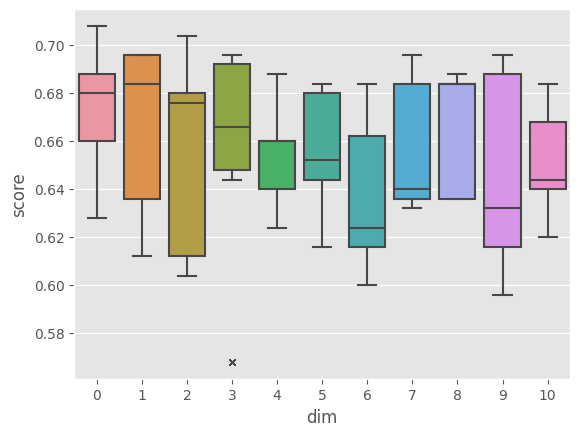

In [248]:
import seaborn

seaborn.boxplot(data=data, x="dim", y="score", flierprops={"marker": "x"})

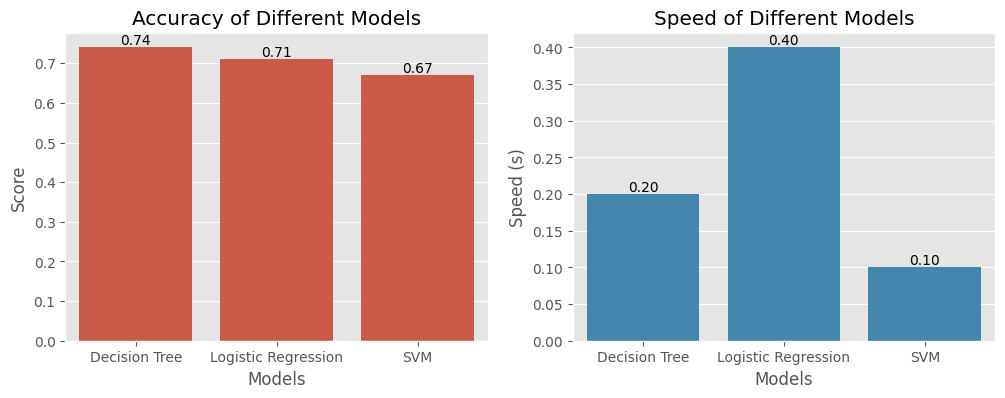

In [242]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

plt.style.use('ggplot')
COLORS = seaborn.color_palette()
f, ax = plt.subplots(1, 2, figsize=(12, 4))

scores = [0.74, 0.71, 0.67] 
models = ['Decision Tree', 'Logistic Regression', 'SVM']

plot_df = pd.DataFrame.from_dict({'Score': scores, 'Models': models})
ax[0].set_title('Accuracy of Different Models')
seaborn.barplot(data=plot_df, x='Models', y='Score', ax=ax[0], color=COLORS[0])
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.2f')

speed = [0.2, 0.4, 0.1] 
models = ['Decision Tree', 'Logistic Regression', 'SVM']

plot_df = pd.DataFrame.from_dict({'Speed (s)': speed, 'Models': models})
ax[1].set_title('Speed of Different Models')
seaborn.barplot(data=plot_df, x='Models', y='Speed (s)', ax=ax[1], color=COLORS[1])
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.2f')

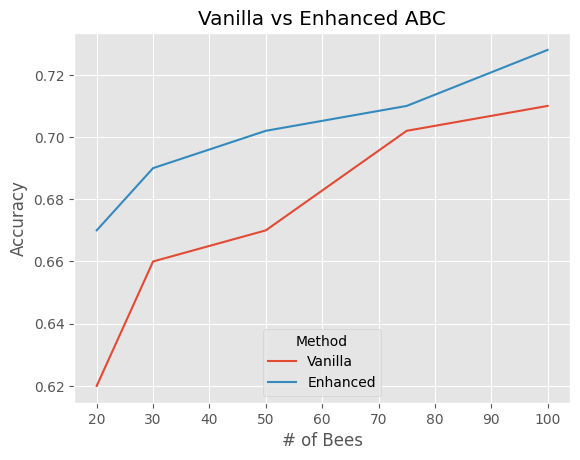

In [243]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np

plt.style.use('ggplot')
COLORS = seaborn.color_palette()
f, ax = plt.subplots()

enhanced_abc = np.array([0.67, 0.69, 0.702, 0.71, 0.728])
vanilla_abc = np.array([0.62, 0.66, 0.67, 0.702, 0.71])
bees = [20, 30, 50, 75, 100]

method = ['Vanilla' for _ in range(5)] + ['Enhanced' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'Accuracy': np.concatenate([vanilla_abc, enhanced_abc]), 'Method': method, '# of Bees': bees + bees})
ax.set_title('Vanilla vs Enhanced ABC')
seaborn.lineplot(data=plot_df, x='# of Bees', y='Accuracy', hue='Method', ax=ax, palette=COLORS[0:2])
seaborn.move_legend(ax, 'lower center')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')